# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
import scipy.io
import tarfile
import csv

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [4]:
print(os.listdir("/data1/datasets/flowers"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['imagelabels.mat', '102flowers.tgz']
Python       : 3.9.12 (main, Jun  1 2022, 11:38:51) 
Numpy        : 1.22.3


NameError: name 'tf' is not defined

In [6]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Setup

In [9]:
EPOCHS               = 25
BATCH_SIZE           = 64 # 128
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 128
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/data1/datasets/flowers/'
PATH = DATA_PATH + "work/"

In [10]:
os.makedirs(PATH,exist_ok=False)

FileExistsError: [Errno 17] File exists: '/data1/datasets/flowers/work/'

In [11]:
# Setting seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [12]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [13]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8189 entries, 0 to 8188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        8189 non-null   object
 1   Category  8189 non-null   object
dtypes: object(2)
memory usage: 128.1+ KB


In [13]:
df['Category'].value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: Category, Length: 102, dtype: int64

In [14]:
df['Category'].nunique()

102

In [15]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH + "102flowers.tgz")
opened_tar.extractall(PATH)
print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_01453.jpg', 'image_02490.jpg', 'image_05444.jpg', 'image_00272.jpg', 'image_01171.jpg']


Пример картинок (random sample)


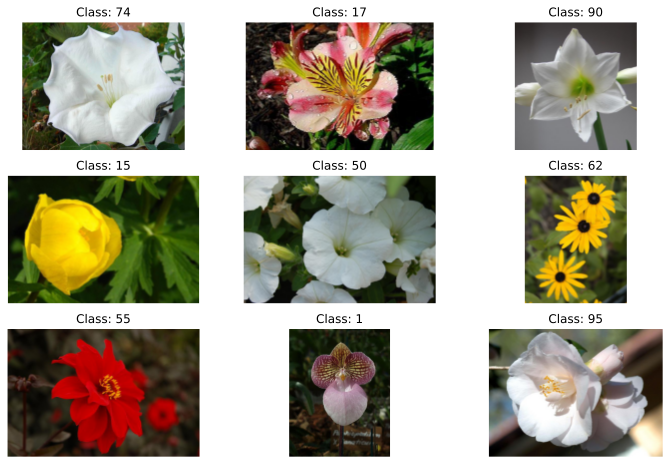

In [16]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


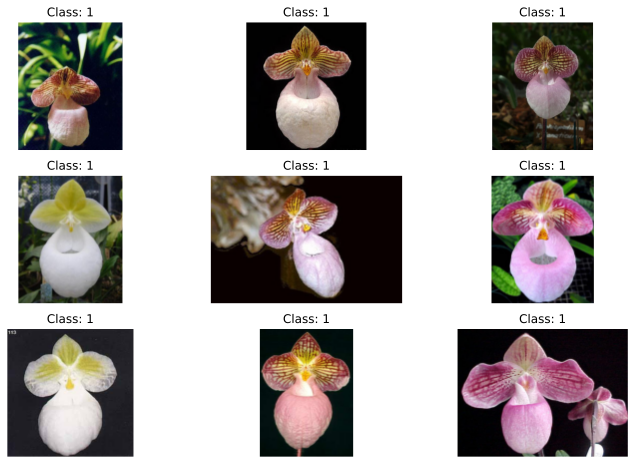

In [17]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

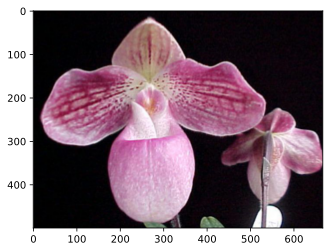

(667, 500)

In [18]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [19]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=RANDOM_SEED, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [20]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [21]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
0      32
6      32
33     32
2      32
26     32
Name: Category, Length: 102, dtype: int64

In [22]:
test_files['Category'].value_counts()

50    52
76    50
72    39
45    39
88    37
      ..
78     8
0      8
20     8
24     8
66     8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [23]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [24]:
# # for v2
# train_datagen = ImageDataGenerator(rescale=1. / 255, 
#                                     rotation_range = 50,
#                                     shear_range=0.2,
#                                     zoom_range=[0.75,1.25],
#                                     brightness_range=[0.5, 1.5],
#                                     width_shift_range=0.1,
#                                     height_shift_range=0.1,
#                                     horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [25]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [26]:
from skimage import io

In [27]:
def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

Пример картинок из test_generator


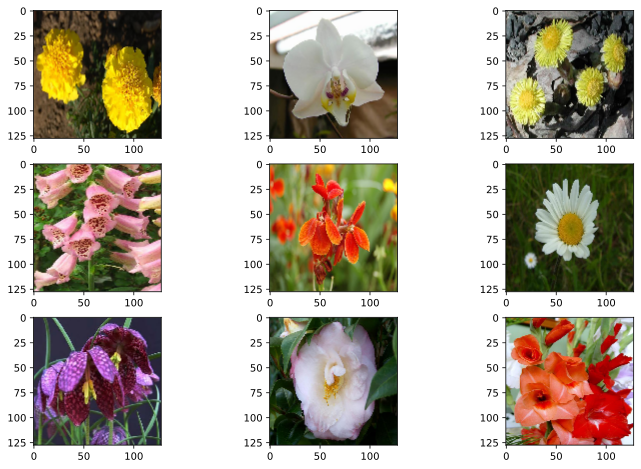

In [28]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [29]:
input_shape

(128, 128, 3)

In [51]:
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Jul 26 15:26:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   43C    P3    84W / 350W |  12049MiB / 12288MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [31]:
model = M.Sequential()

# model layer 1
model.add(L.Convolution2D(128, (3, 3), input_shape=input_shape, activation='relu', padding='same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(128, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())

# Pooling layer 1
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.2))

# model and pooling layer 2
model.add(L.Convolution2D(256, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(256, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())

model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.3))

# model and pooling layer 3.
model.add(L.Convolution2D(512, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(512, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())

model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.3))


# Flattening
model.add(L.Flatten())

# Full connection
model.add(L.Dense(512, activation='relu'))
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                        

In [33]:
# сколько слоев
print(len(model.layers))

22


In [34]:
len(model.trainable_variables)

28

## Fit

In [35]:
MODEL_PATH = DATA_PATH + "model/"
os.makedirs(MODEL_PATH, exist_ok=False)

In [36]:
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [37]:
#LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(learning_rate=LR), metrics=["accuracy"])

In [38]:
scores = model.evaluate(test_generator, steps=1, verbose=1) # model.evaluate_generator
print("Accuracy: %.2f%%" % (scores[1]*100))

2022-07-26 14:52:56.862144: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-26 14:52:56.862526: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 2s 2s/step - loss: 4.6257 - accuracy: 0.0156
Accuracy: 1.56%


In [39]:
# Обучаем
history = model.fit( # model.fit_generator
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/25
102/102 [==============================] - ETA: 0s - loss: 10.4249 - accuracy: 0.0348
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 24s 211ms/step - loss: 10.4249 - accuracy: 0.0348 - val_loss: 8.4993 - val_accuracy: 0.0294
Epoch 2/25
102/102 [==============================] - ETA: 0s - loss: 4.6701 - accuracy: 0.0603
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 23s 222ms/step - loss: 4.6701 - accuracy: 0.0603 - val_loss: 6.7253 - val_accuracy: 0.0206
Epoch 3/25
102/102 [==============================] - ETA: 0s - loss: 4.5044 - accuracy: 0.0752
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 23s 222ms/step - loss: 4.5044 - accuracy: 0.0752 - val_loss: 7.1780 - val_accuracy: 0.0288
Epoch 4/25
102/102 [==============================] - ETA: 0s - loss: 4.3835 - accuracy: 0.0822

In [40]:
model.save(MODEL_PATH + 'model_last.hdf5')
model.load_weights(MODEL_PATH + 'model_last.hdf5')

In [41]:
scores = model.evaluate(test_generator, steps=1, verbose=1) # model.evaluate_generator
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 221ms/step - loss: 5.5003 - accuracy: 0.1406
Accuracy: 14.06%


In [42]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.show()

    #plt.figure()
    plt.figure(figsize=(10,5))
    plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

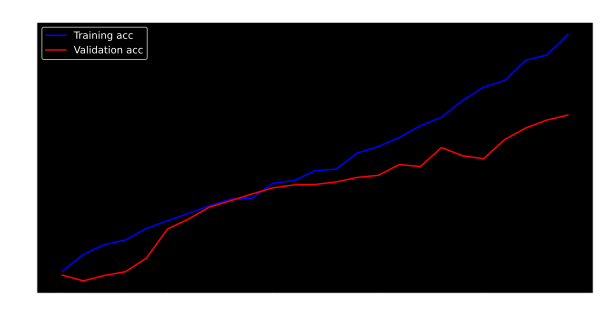

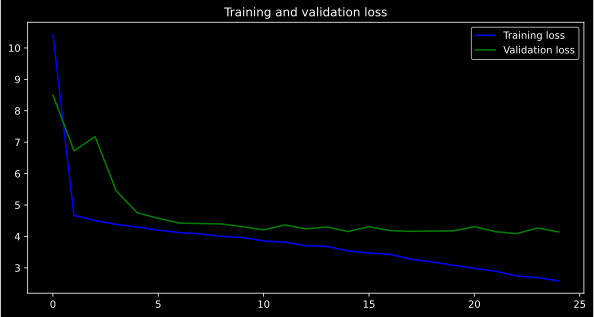

In [43]:
plot_history(history)

In [44]:
K.clear_session()

In [45]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(learning_rate=LR), metrics=["accuracy"])

In [46]:
history = model.fit( # model.fit_generator
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/25
102/102 [==============================] - ETA: 0s - loss: 2.2198 - accuracy: 0.4430
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 26s 253ms/step - loss: 2.2198 - accuracy: 0.4430 - val_loss: 3.8416 - val_accuracy: 0.3150
Epoch 2/25
102/102 [==============================] - ETA: 0s - loss: 2.1238 - accuracy: 0.4637
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 26s 252ms/step - loss: 2.1238 - accuracy: 0.4637 - val_loss: 3.7958 - val_accuracy: 0.3181
Epoch 3/25
102/102 [==============================] - ETA: 0s - loss: 2.0157 - accuracy: 0.4856
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
102/102 [==============================] - 26s 253ms/step - loss: 2.0157 - accuracy: 0.4856 - val_loss: 3.7870 - val_accuracy: 0.3194
Epoch 4/25
102/102 [==============================] - ETA: 0s - loss: 1.9815 - accuracy: 0.4899
E

In [47]:
model.save(MODEL_PATH + 'model_last.hdf5')
model.load_weights(MODEL_PATH + 'model_last.hdf5')

In [48]:
scores = model.evaluate(test_generator, steps=1, verbose=1) # evaluate_generator
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 225ms/step - loss: 5.1067 - accuracy: 0.2969
Accuracy: 29.69%


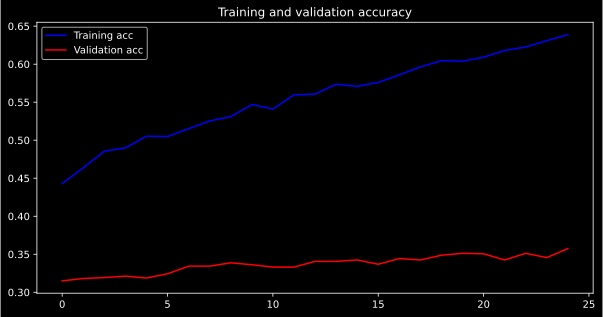

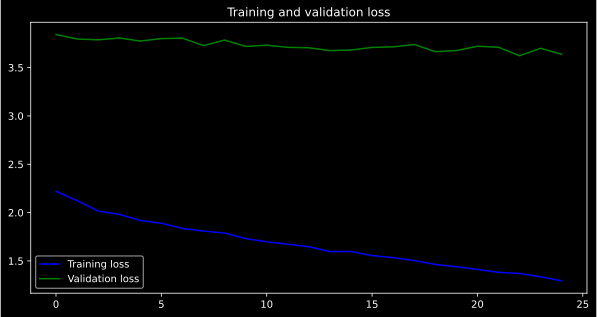

In [49]:
plot_history(history)

In [50]:
# Clean PATHs
import shutil
shutil.rmtree(PATH)
shutil.rmtree(MODEL_PATH)